### Using Tree data

In [1]:
import pandas as pd
from sklearn import gaussian_process
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

dendro = pd.read_feather("data/17766_12.feather")
dendro.dendroNr = (
    dendro[["dendroNr", "year"]].astype(str).agg("_".join, axis=1)
)  # Merge tree and year
dendro

,dendroNr,year,DOY,species,Plot,growth,dbh
0,HA_001_2012,2012,0,Beech,HEW40,0.000000,151437.432617
1,HA_001_2012,2012,1,Beech,HEW40,0.154100,151437.586208
2,HA_001_2012,2012,2,Beech,HEW40,1.460225,151438.892708
3,HA_001_2012,2012,3,Beech,HEW40,4.169183,151441.601646
4,HA_001_2012,2012,4,Beech,HEW40,3.907183,151441.340000
...,...,...,...,...,...,...,...
30805,SH_076_2013,2013,178,Beech,SEW4,3909.054208,219194.517313
30806,SH_076_2013,2013,179,Beech,SEW4,3908.649604,219194.112896
30807,SH_076_2013,2013,180,Beech,SEW4,3908.473708,219193.937042
30808,SH_076_2013,2013,181,Beech,SEW4,3908.421000,219193.883875


211309749.01175413 at 0.4**2 * RBF(length_scale=20)
34739864.12036822 at 0.4**2 * RBF(length_scale=20)
27016093.104886495 at 0.4**2 * RBF(length_scale=20)


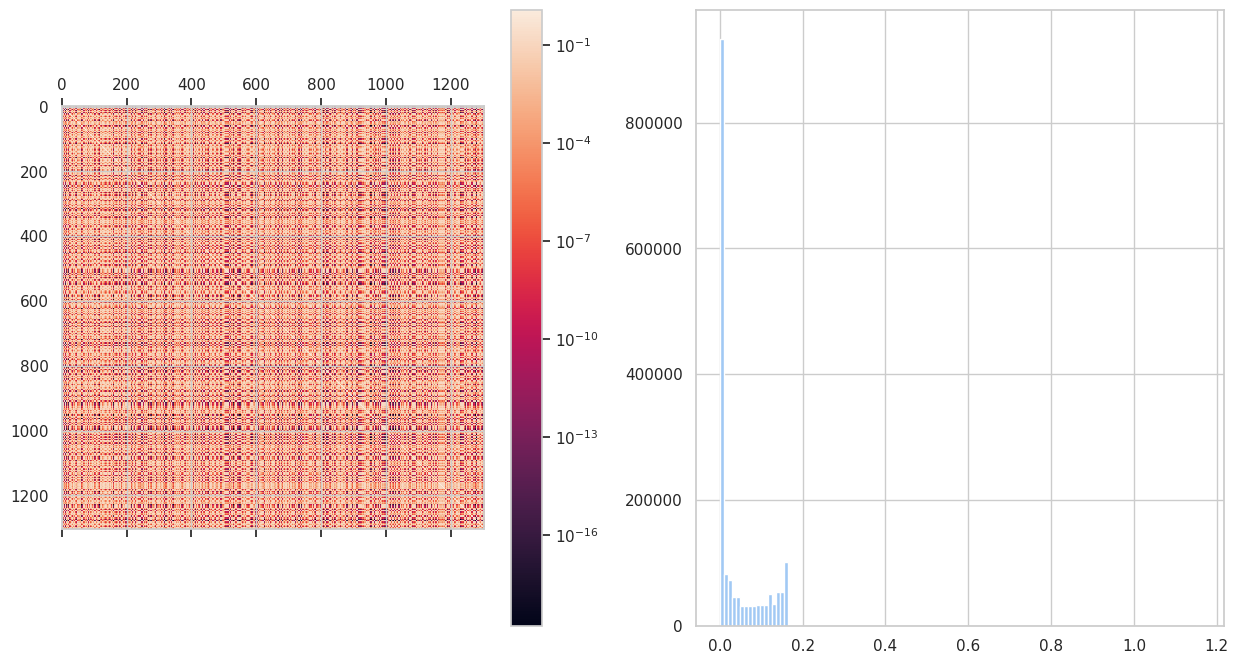

In [52]:
import matplotlib
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, ExpSineSquared

tree_models = [
    gaussian_process.GaussianProcessRegressor(
        0.4**2 * RBF(20, length_scale_bounds=(0.1, 1000)), n_restarts_optimizer=10, alpha=1, optimizer=None
    )
    for _ in range(3)
]

X = np.array(range(183)).reshape(-1, 1)

for i, tree_model in enumerate(tree_models):
    # Filter to prevent overfitting to data mean
    filt = dendro[dendro.species.eq(pd.unique(dendro.species)[i])]
    filt = filt.sample(int(0.05*len(filt)))

    tree_model.fit(filt.DOY.array.reshape(-1, 1), filt.growth)
    print(-tree_model.log_marginal_likelihood_value_, 'at', tree_model.kernel_)

    if i == 0:
        fig, ax = plt.subplots(figsize=(15,8), ncols=2)
        K = tree_model.L_ @ tree_model.L_.T
        cax = ax[0].matshow(K, norm=matplotlib.colors.LogNorm())
        fig.colorbar(cax)
        ax[1].hist(K.flatten(), bins=120)

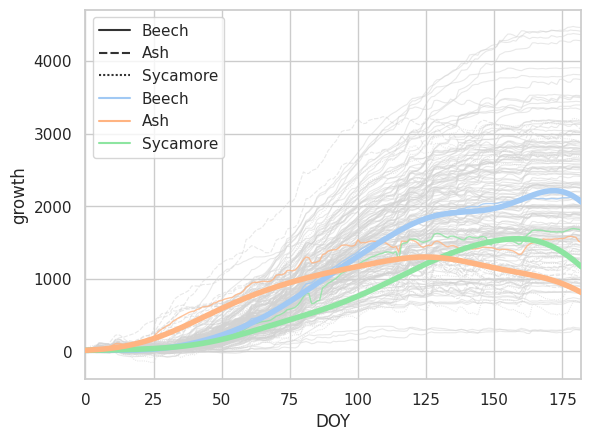

In [53]:
fig = plt.figure()
sns.set_theme(style="whitegrid", palette="pastel")

# All lines
sns.lineplot(
    data=dendro,
    x="DOY",
    y="growth",
    style="species",
    units="dendroNr",
    lw=0.8,
    estimator=None,
    c="lightgray",
    alpha=0.5,
)

plt.gca().set(xlim=(0, 182))

# Plot means
sns.lineplot(
    data=dendro,
    x="DOY",
    y="growth",
    hue="species",
    # estimator=None,
    # errorbar=('ci', 99),
    errorbar=None,
    lw=1,
    zorder=2,
    alpha=0.8,
)

X_test = np.linspace(0, 182, 300, True)
# Plot GP
for i, tree_model in enumerate(tree_models):
    filt = dendro[dendro.species.eq(pd.unique(dendro.species)[i]) & dendro.DOY.mod(30).eq(0)]
    sns.lineplot(
        x=X_test,
        y=tree_model.predict(X_test.reshape(-1, 1)).ravel(),
        lw=4,
        zorder=3,
        color=sns.color_palette()[i if i == 0 else [2, 1][i - 1]],
    )

plt.show()